### If running this notebook in Google Colab, run the following cells first. Make sure you've placed the Q12 and Q34 sales data in the same Google Drive folder as this notebook.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [ ]:
# Replace the ID with ID of file you want to access
Q12 = drive.CreateFile({'id':'1pwF6XDL_NcJQfDuFdZY85_Vo8qxSsWxS'}) 
Q12.GetContentFile('sales_Q12_2019.csv') 
Q34 = drive.CreateFile({'id':'165FxdfiSFR0-cbqieMe6qGv2GfFbKF7N'}) 
Q34.GetContentFile('sales_Q34_2019.csv') 

### Import the necessary modules

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in the CSV file containing the California sales data for Quarters 1 and 2

Then examine the data's shape and first few rows

In [ ]:
df_sales = pd.read_csv("sales_Q12_2019.csv")
print(df_sales.shape)
df_sales.head()

(5837, 76)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP,dealer_state,date
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610,California,2019-04-28
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505,California,2019-03-14
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890,California,2019-06-12
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055,California,2019-03-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830,California,2019-01-23


### Begin cleaning the data

Eliminate the `'dealer_state'` and `'date'` columns. The former is useless to our model, since we already know that our dataset is restricted to California sales. While we could possibly extract useful information from the `'date'` column (for example, to determine whether more cars are sold on weekends than weekdays), we'll be focusing on car configurations in this exercise.

In [ ]:
df_sales = df_sales.drop(columns=['dealer_state','date'])
df_sales.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830


### Read in the CSV file containing the California sales data for Quarters 3 and 4

The `'dealer_state'` and `'date'` columns have already been eliminated in this dataset, so you don't need to worry about them here. Examine the data's shape and first few rows.

In [ ]:
### START CODE HERE ###
# Read in the Q34 data
df_pred = pd.read_csv("sales_Q34_2019.csv")
# Print the shape of the data
print(df_pred.shape)
# Examine the first few rows of the data
df_pred.head()
### END CODE HERE ###

(6666, 74)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,51355
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71580
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66790
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72330
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55370


# Task I. Consolidate data by finding numbers of unique car combinations sold for training and test data sets

You've probably noticed that 73 of the 74 columns in our Q12 and Q34 datasets are one-hot-encoded representations of the car's `'main_type'`, `'engine'`, and `'sales_version'` values. You've probably also noticed that the final column is the car's `'MSRP'`, or manufacturer's (Tesla's, in this case) suggested retail price. In its current form, the sales data doesn't contain a target. The car's `'main_type'`, `'engine'`, `'sales_version'`, and `'MSRP'` values are all known to us before the time of the sale and do not, by themselves, offer us anything which we can predict. 

However, each row represents the sale of a single car. If we define a unique car type by its combination of `'main_type'`, `'engine'`, and `'sales_version'` values, the number of rows displaying that combination corresponds to the number of times during that half of the year that that distinct type of car was sold in California. Therefore, we can make training and test datasets where each row now corresponds to a unique car type, and the target value is how many times that car type was sold in California during a given half of the year.

## This task requires data wrangling!
## Create functions that read the Q12 (df_sales) and Q34 (df_pred) data sets and create train_X, train_Y, test_X and test_Y, respectively. Use pandas and NumPy as needed.

train_X, test_X = unique row combinations without MSRP column

train_Y, test_Y = number of unique cars sold

In [ ]:
def get_features_and_targets(df):
    ### START CODE HERE ###
    # Create the local data DataFrame as a copy of the input df DataFrame, minus the 'MSRP' column
    data = df.drop(columns=['MSRP'])
    
    # Use the value_counts() method for DataFrames to store the targets as a NumPy array of the 
    # normalized sales counts associated with each unique combination of 'main_type', 'engine', 
    # and 'sales_version' values in the data DataFrame
    # Make sure the counts are unsorted, so they're listed in order of the combination's first appearance
    # in the data DataFrame, and that the array is 2D, with 1 entry per row
    Y = np.array(data.value_counts(sort=False, normalize=True))[:, np.newaxis]
    # Get a list of the column names of the data DataFrame
    subset_names = data.columns.to_list()
    # Use the drop_duplicates() method on the df DataFrame to store the features data as a NumPy array where
    # each row corresponds to a unique combination of 'main_type', 'engine', and 'sales_version' values
    # Make sure to set the subset parameter to subset_names, so the 'MSRP' column isn't included in the 
    # uniqueness calculations
    X = np.array(df.drop_duplicates(subset=subset_names))
    # Scale and shift the 'MSRP' column so its values fall in the range [0,1]
    # You might find NumPy's ptp() function useful
    X[:,-1] = ( X[:,-1] - min(X[:,-1]) ) / np.ptp(X[:,-1])
    # Return features and targets
    return X, Y
    ### END CODE HERE ###

### Extract features and targets as defined above from both the Q12 and Q34 datasets

In [ ]:
### START CODE HERE ###
# Extract training features and targets from the Q12 data
train_X, train_Y = get_features_and_targets(df_sales)
# Extract test features and targets from the Q34 data
test_X, test_Y = get_features_and_targets(df_pred)
### END CODE HERE ###
print(f"Number of unique cars in Q12 = {len(train_Y)}")
print(f"Number of unique cars in Q34 = {len(test_Y)}")

Number of unique cars in Q12 = 66
Number of unique cars in Q34 = 71


You probably noticed that the Q12 and Q34 datasets contained differing numbers of distinct cars. Clearly, some new models were introduced by Q3, but were any discontinued by the end of Q2? Let's find out.

In [ ]:
# How many unique cars in 2012 (Q1:Q4)?
### START CODE HERE ### 
# Concatenate the Q12 and Q34 DataFrames into a single DataFrame
df_full = pd.concat([df_sales, df_pred])
# Extract features and targets from the concatenated Q14 data
data_X, data_Y = get_features_and_targets(df_full)
### END CODE HERE ###
print(f"Number of unique cars in Q12 and Q34 = {len(data_Y)}")

Number of unique cars in Q12 and Q34 = 80


In [ ]:
### START CODE HERE ###
#models_q12_or34 refers to (A Union B), models_q14 refers to (A intersection B)
common = len(train_Y)+len(test_Y) - len(data_Y)
print('Cars sold in both halves of 2019: ', common)
### END CODE HERE ###

Cars sold in both halves of 2019:  57


# Task II: Visualize the training and test targets any way you see fit

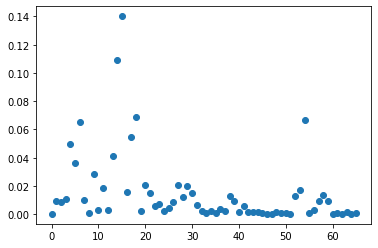

In [ ]:
# Visualize the training targets
### START CODE HERE ###
plt.scatter(range(len(train_Y)), train_Y)
plt.show()
### END CODE HERE ###

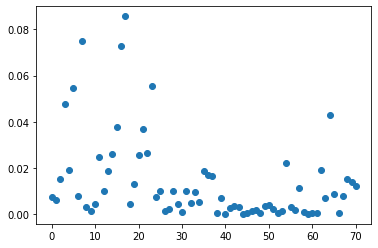

In [ ]:
# Visualize the test targets
### START CODE HERE ###
plt.scatter(range(len(test_Y)), test_Y)
plt.show()
### END CODE HERE ###

# Task III: Apply Gradient Descent (Linear, Polynomial)

Initialize the $\theta$ parameters as a column vector of zeros, one for every feature in the training data plus one for bias. 

Also set hyperparameters for learning rate and maximum number of iterations through the training data.

In [ ]:
# Initialize learned parameters theta and hyperparameters
s_theta = np.zeros((train_X.shape[1]+1, 1))
s_learning_rate = 0.001
s_max_iteration = 1000

### Hypothesis Function

Define your hypothesis function $h$ (which you use to make predictions $\hat{Y}$ as the matrix product of your features data X and parameters theta, in that order. 

Don't forget to add a 0th column of ones to X to account for the bias/offset parameter.

In [ ]:
# Define your hypothesis function according to the instructions above
def h (theta, X) :
    ### START CODE HERE ###
    tempX = np.concatenate((np.ones((X.shape[0],1)),X), axis=1)
    return np.matmul(tempX,theta)
    ### END CODE HERE ###

Define your loss function as **half** the MSE (mean squared error) between your actual and predicted Y values. 

Recall that the predicted Y values are a function of theta and X.


In [ ]:
# Loss Function
def loss (theta, X, Y) :
    ### START CODE HERE ###
    return 0.5*np.mean(np.square(Y-h(theta,X)) )
    ### END CODE HERE ###
loss(s_theta, train_X, train_Y)

0.0004433887668784626

### Gradient of Hypothesis Function

One can verify through straightforward (if somewhat tedious) multivariable calculus that the gradient of the loss function $J$ with respect to the parameters $\theta$ is 

$$ \frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y})$$.

Here, $X$ has been augmented with a bias column. 

Set up a function to compute this gradient.

In [ ]:
def gradient (theta, X, Y) :
    ### START CODE HERE ###
    # Create a temporary X array with an added 0th bias column
    tempX = np.concatenate((np.ones((X.shape[0],1)),X), axis=1)
    # Compute the gradient according to the instructions above
    d_theta = -1/X.shape[0]*np.dot(tempX.T, (Y-h (theta, X)))
    ### END CODE HERE ###
    return d_theta

### Gradient Descent

Set up a function to train your linear regression model with gradient descent, i.e. calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. Recall that the general gradient descent update formula is $\theta := \theta - \alpha \frac{\partial J}{\partial \theta}$. We've provided the skeleton of a stochastic gradient descent function, but you're welcome to experiment with batch and/or minibatch gradient descent. Also recall that the aforementioned gradient descent methods differ in how frequently they calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. 

In [ ]:
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    ### START CODE HERE ###
    # Initialize the cost as an array of zeros, one for each iteration through the dataset
    cost = np.zeros(max_iteration)
    # Loop over the dataset
    for i in range(max_iteration):
        # Loop over each row in the dataset
        for j in range(X.shape[0]):
            # Compute the gradient from the current row in X and the associated Y value
            # Make sure that both X and Y are represented as 2D row vectors
            d_theta = gradient(theta, X[j:], Y[j])
            # Update theta
            #print(d_theta.shape)
            theta = theta - learning_rate*d_theta
        # Update the cost array for the current iteration
        cost[i] = loss (theta, X, Y)
    ### END CODE HERE ###
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

In [ ]:
s_theta, s_cost = stochastic_gradient_descent(s_theta, train_X, train_Y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.000423825799654156
iteration :  100  loss :  0.0003160718299523339
iteration :  200  loss :  0.0003137491598998187
iteration :  300  loss :  0.0003126176205871965
iteration :  400  loss :  0.00031173495499710536
iteration :  500  loss :  0.0003109691140045921
iteration :  600  loss :  0.000310295121487866
iteration :  700  loss :  0.0003097041201610478
iteration :  800  loss :  0.00030918863001414866
iteration :  900  loss :  0.00030874044205076774


### Generate Predictions from Test Data

In [ ]:
### START CODE HERE ###
GD_P = h(s_theta, test_X)
### END CODE HERE ###
# Set any negative predictions to 0
GD_P[GD_P<0] = 0

SGD_Predict = GD_P

### Visualize the predicted and actual test labels

RMSE, R2 = 0.00041 , 0.18906


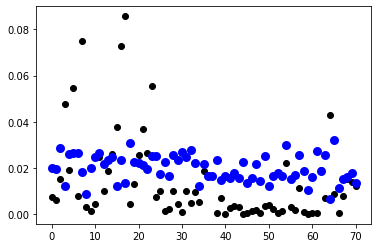

In [ ]:
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(GD_P)), GD_P, color='blue', linewidth=3)
from sklearn.metrics import mean_squared_error as MSE

# This function evaluates the R**2 statistic
# Source: https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
def r2(Yt,Yp):
    yhat = Yp                         
    ybar = np.sum(Yt)/len(Yt)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((Yt - ybar)**2)    
    results = ssreg / sstot
    return results


SGD = ["RMSE, R2 =", str(round(MSE(test_Y,GD_P),5)),',', str(round(r2(test_Y,GD_P),5))]
SGD = ' '.join(SGD)
print(SGD)

# Task IV: Normal Equations

Since our training dataset isn't very large, let's generate predictions using the normal equations: 

$$W = (X^T \cdot X)^{-1} \cdot X^T \cdot Y$$ 
$$\hat{Y} = X \cdot W$$

and see how they compare to the predictions which we obtained from gradient descent.
Ensure $$Y=[nx1], W=[dx1], X[nxd]$$ dimensions, respectively.

In [ ]:
### START CODE HERE ###
# Compute the inverse of the matrix product of the transpose of X and X
X= train_X
Y= train_Y
inv1 = np.linalg.pinv(np.dot(X.T,X))

# Compute W using the first of the Normal Equations
W1 = np.dot(np.dot(inv1,X.T),Y)
# Compute the predicted Y values using the second of the Normal Equations
PN1 = np.dot(test_X,W1)
### END CODE HERE ###

# Set any negative predictions to 0
PN1[np.where(PN1<0)]=0

Normal_Predict = PN1



RMSE, R2 for prediction all features = 0.0005596570062877894 0.8479142625775232
RMSE, R2 = 0.00056 , 0.84791


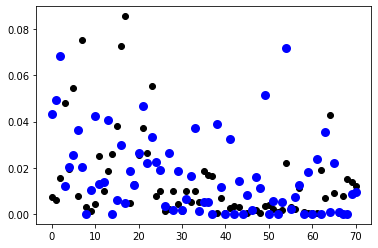

In [ ]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN1)), PN1, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1), r2(test_Y,PN1)) #[Low error high corr]

Normal = ["RMSE, R2 =", str(round(MSE(test_Y,PN1),5)),',', str(round(r2(test_Y,PN1),5))]
Normal = ' '.join(Normal)
print(Normal)

### Regularized Normal Equations

In [ ]:
print('Recall that our training features array train_X has')
print(f'm = {train_X.shape[0]} rows and n = {train_X.shape[1]} columns')

Recall that our training features array train_X has
m = 66 rows and n = 74 columns


`train_X` is thus wider than it is tall, which suggests that the regularized normal equations might perform better in generating label predictions. In this case, we modify the first of the normal equations given above to 

$$W = (X^T \cdot X + \lambda m I)^{-1} \cdot X^T \cdot Y$$.

Here, $\lambda$ is the regularization parameter and $m$ is the number of rows in $X$.

### Repeat the previous parts of Task IV, but this time incorporate regularization

RMSE, R2 for prediction all features = 0.0004322737811568533 0.2614195347874885
RMSE, R2 = 0.00043 , 0.26142


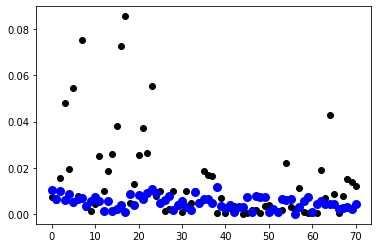

In [ ]:
### START CODE HERE ###
# Compute the inverse of the matrix product of the transpose of X and X
lambda_1 =1
X= train_X
Y= train_Y
inv1 = np.linalg.pinv(np.dot(X.T,X) + lambda_1*X.shape[0]*np.identity(X.shape[1]))

# Compute W using the first of the Normal Equations
W1 = np.dot(np.dot(inv1,X.T),Y)
# Compute the predicted Y values using the second of the Normal Equations
PN1 = np.dot(test_X,W1)
### END CODE HERE ###

# Set any negative predictions to 0
PN1[np.where(PN1<0)]=0

# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN1)), PN1, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1), r2(test_Y,PN1)) #[Low error high corr]

NormalReg = ["RMSE, R2 =", str(round(MSE(test_Y,PN1),5)),',', str(round(r2(test_Y,PN1),5))]
NormalReg = ' '.join(NormalReg)
print(NormalReg)

NormalReg_Predict = PN1

# Task V: Non-linear Regression Models (GLM, DT) 

### Generalized Linear Models

`sm` (our alias for `statsmodels.api`) contains a `GLM` class. Use it to instantiate a model. The relevant parameters are training labels, training features, and `ffamily`, i.e. the family of distributions to which we assume our prediction errors belong. Some potentially good choices for `ffamily` include Gaussian, Gamma, and Logit.

In [ ]:
# GLM 
import statsmodels.api as sm
### START CODE HERE ###
# Instantiate the GLM
exog, endog = sm.add_constant(train_X), train_Y
mod = sm.GLM(endog, exog,
             family=sm.families.Poisson(link=sm.families.links.log))

# Train the GLM
res = mod.fit()
G_P = res.predict(sm.add_constant(train_X))
G_P
### END CODE HERE ###
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   66
Model:                            GLM   Df Residuals:                       34
Model Family:                 Poisson   Df Model:                           31
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.0445
Date:                Sun, 23 May 2021   Deviance:                      0.59438
Time:                        17:36:31   Pearson chi2:                    0.632
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2492     18.073     -0.235      0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  import sys
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


### Generate predictions from the test data

In [ ]:
### START CODE HERE ###
G_P = res.predict(sm.add_constant(test_X))
### END CODE HERE ###
# Set any negative predictions to 0
G_P[G_P<0]=0

GLM_Predict = G_P

RMSE, R2 = 0.00097844816738423 1.918738879261513


'RMSE, R2 = 0.00098 , 1.91874'

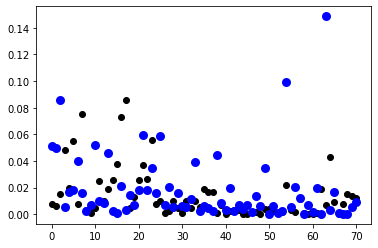

In [ ]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(G_P)), G_P, color='blue', linewidth=3)
print("RMSE, R2 =", MSE(test_Y,G_P), r2(test_Y,G_P)) 

GLM = ["RMSE, R2 =", str(round(MSE(test_Y,G_P),5)),',', str(round(r2(test_Y,G_P),5))]
GLM = ' '.join(GLM)
GLM

### Random Forest Regression

Use the `RandomForestRegressor` from `sklearn.ensemble` to generate predictions. The relevant parameters are the `max_depth` of the trees and the `random_state`, to ensure reproducibility.

In [ ]:
### START CODE HERE ###
from sklearn.ensemble import RandomForestRegressor
# Instantiate the random forest regression model
regr =  RandomForestRegressor()

# Train the model
regr.fit(train_X, train_Y)

# Generate predictions from the test data
pred_rf = regr.predict(test_X)
### END CODE HERE ###

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [ ]:
# Set any negative predictions to 0
pred_rf[np.where(pred_rf<0)]=0

RF_Predict = pred_rf

RMSE, R2 for Decision Trees= 0.000628350621252098 0.8936054481753692
RMSE, R2 = 0.00063 , 0.89361


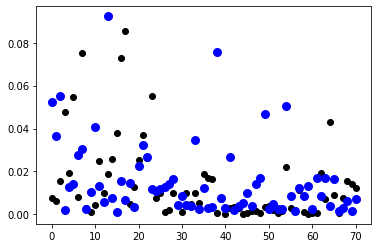

In [ ]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(pred_rf)), pred_rf, color='blue', linewidth=3)
print("RMSE, R2 for Decision Trees=", MSE(test_Y,pred_rf), r2(test_Y,pred_rf)) #[Low error high corr]
RF = ["RMSE, R2 =", str(round(MSE(test_Y,pred_rf),5)),',', str(round(r2(test_Y,pred_rf),5))]
RF = ' '.join(RF)
print(RF)

## Populate the table below with the results of your experiments above. Which models performed best?

In [ ]:
##Results
print('1. Gradient Descent   -' , SGD)
print('2. Normal Equations   -', Normal)
print('3. Regularized Normal -', NormalReg)
print('4. GLM                -', GLM)
print('5. Decision Trees     -', RF)




1. Gradient Descent   - RMSE, R2 = 0.00041 , 0.18906
2. Normal Equations   - RMSE, R2 = 0.00056 , 0.84791
3. Regularized Normal - RMSE, R2 = 0.00043 , 0.26142
4. GLM                - RMSE, R2 = 0.00098 , 1.91874
5. Decision Trees     - RMSE, R2 = 0.00063 , 0.89361


## Results
---------------------------------------------------------------------------
Method                                          |  RMSE             | R2               |
-------------------------------------------------------------------------------------
1. Gradient Descent   - RMSE, R2 = 0.00041 , 0.18906
2. Normal Equations   - RMSE, R2 = 0.00043 , 0.26142
3. Regularized Normal - RMSE, R2 = 0.00043 , 0.26142
4. GLM                - RMSE, R2 = 0.00098 , 1.91874
5. Decision Trees     - RMSE, R2 = 0.0007 , 1.10362

Based on RMSE - Gradient Descent solution is the most accurate.

## Finally, pick some car types for which your models over- and under-predicted sales. Attempt to determine the root causes. Write your findings below.

# Findings

To identify over and under predicitons the model of the choice was the **gradient descend model** (as this was the best model based on RMSE on test set).

Over and Under Predictins are defined as the cases where models under and over-predicted by more than an difference of 0.02. To understand the reason for over-under predicitons test and train sets were compared. 

Firstly there are car models which are missing from the training set. Since these cars were not explicitly modeled one can expect higher inaccuracy for such data.

In addition to this for cases of poor predicitons we see a very high difference in train and test target values.

1. For cases where model predictions are within margin of 0.02, the proportion of sales in test set compare to train set only changed by -0.006.
2. For cases where models over-perdict the propotion of sales in test set compare to test set changed by -0.026.
3. For cases where models under predict the propotion of sales in test set compare to test set changed by -0.057. 


The models built here lacks time-series features that can enable capture this change in relative proportion of sales over-time. Hence we can expect model predictions to be weak for cases where relative proportion of Q1/Q2 vs Q3/Q4 sales are drastically different.

In [ ]:
# data = pd.DataFrame(np.concatenate((SGD_Predict,Normal_Predict,NormalReg_Predict,GLM_Predict.reshape(71,1),RF_Predict.reshape(71,1), test_Y), axis=1))
# data.columns = ['SGD_Predict','Normal_Predict','NormalReg_Predict','GLM_Predict','RF_Predict','test_Y']

# data['Underpredict'] = data.apply(lambda x: 1 if all(x['test_Y']>x[['SGD_Predict','Normal_Predict','NormalReg_Predict','GLM_Predict','RF_Predict']]) else 0 , axis=1)
# data['Overpredict'] = data.apply(lambda x: 1 if all(x['test_Y']<x[['SGD_Predict','Normal_Predict','NormalReg_Predict','GLM_Predict','RF_Predict']]) else 0 , axis=1)
# Over = data.loc[data['Overpredict'] == 1]
# Under = data.loc[data['Underpredict'] == 1]

# print('Examples where all models Over-predict')

# TestFeatures = pd.DataFrame(np.concatenate((test_X, test_Y), axis=1))
# TrainFeatures = pd.DataFrame(np.concatenate((train_X, train_Y), axis=1))

# Over_Features = TestFeatures[TestFeatures.index.isin(Over.index)]
# Under_Features = TestFeatures[TestFeatures.index.isin(Under.index)]


# Over_Features['hash']  = pd.DataFrame(Over_Features.iloc[:,:-1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)) 
# Under_Features['hash'] = pd.DataFrame(Under_Features.iloc[:,:-1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)) 
# TrainFeatures['hash']  = pd.DataFrame(TrainFeatures.iloc[:,:-1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)) 

# Over_Features = Over_Features.iloc[:,range(-2,0)]
# Over_Features.columns = ['test_y','hash']
# Under_Features = Under_Features.iloc[:,range(-2,0)]
# Under_Features.columns = ['test_y','hash']
# TrainFeatures = TrainFeatures.iloc[:,range(-2,0)]
# TrainFeatures.columns = ['train_y','hash']
# #Over_Features.merge(TrainFeatures, on='hash', how="left")

# Over_Features.merge(TrainFeatures, on='hash', how="left") 
# Under_Features.merge(TrainFeatures, on='hash', how="left") 

data = pd.DataFrame(np.concatenate((SGD_Predict, test_Y), axis=1))
colnames = ['SGD_Predict','test_Y']
data.columns = colnames
data['Underpredict'] = data.apply(lambda x: 1 if all(x['test_Y']-x[colnames[:-1]]> 0.02) else 0 , axis=1)
data['Overpredict']  = data.apply(lambda x: 1 if all(x['test_Y']-x[colnames[:-1]]<-0.02) else 0 , axis=1)
Over = data.loc[data['Overpredict'] == 1]
Under = data.loc[data['Underpredict'] == 1]
Decent = data.loc[(data['Underpredict'] == 0) & (data['Overpredict'] == 0)]

print('Examples where all models Over-predict')

TestFeatures = pd.DataFrame(np.concatenate((test_X, test_Y), axis=1))
TrainFeatures = pd.DataFrame(np.concatenate((train_X, train_Y), axis=1))

Over_Features   = TestFeatures[TestFeatures.index.isin(Over.index)]
Under_Features  = TestFeatures[TestFeatures.index.isin(Under.index)]
Decent_Features = TestFeatures[TestFeatures.index.isin(Decent.index)]

Over_Features['hash']   = pd.DataFrame(Over_Features.iloc[:,:-1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)) 
Under_Features['hash']  = pd.DataFrame(Under_Features.iloc[:,:-1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1))
Decent_Features['hash'] = pd.DataFrame(Decent_Features.iloc[:,:-1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)) 
TrainFeatures['hash']   = pd.DataFrame(TrainFeatures.iloc[:,:-1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)) 

Over_Features = Over_Features.iloc[:,range(-2,0)]
Over_Features.columns = ['test_y','hash']
Under_Features = Under_Features.iloc[:,range(-2,0)]
Under_Features.columns = ['test_y','hash']
Decent_Features = Decent_Features.iloc[:,range(-2,0)]
Decent_Features.columns = ['test_y','hash']
TrainFeatures = TrainFeatures.iloc[:,range(-2,0)]
TrainFeatures.columns = ['train_y','hash']
#Over_Features.merge(TrainFeatures, on='hash', how="left")
Over_Features = Over_Features.merge(TrainFeatures, on='hash', how="left")
Under_Features = Under_Features.merge(TrainFeatures, on='hash', how="left")
Decent_Features = Decent_Features.merge(TrainFeatures, on='hash', how="left")


print((Over_Features['test_y']-Over_Features['train_y']).mean())
print((Under_Features['test_y']-Under_Features['train_y']).mean())
print((Decent_Features['test_y']-Decent_Features['train_y']).mean())



Examples where all models Over-predict
-0.02505864200719655
0.05773087893972589
-0.00575456466325063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
data.columns[:-1]

Index(['SGD_Predict', 'Normal_Predict', 'NormalReg_Predict', 'GLM_Predict',
       'RF_Predict', 'test_Y', 'Underpredict'],
      dtype='object')

# **Summary and Discussion:** **Discuss** "What would you report back as best model for prediction?" 
# Think in terms of Data, Process and Outcomes specifically.
## Consider the following:
1. Can you process the data in some other way? 
2. Given a new data set on the job, how would you report the best "method"? What are the steps to always follow? 
3. What is the metric/metrics you would use to report your results?

#Share screen and discuss findings. Think about generalizability (something that works across data sets)


#Discussion

Based on RMSE - Gradient Descent solution is the most accurate.

1. Data processing can be improved by using pandas data transformation functions.

2. With a new data -set we can again compare accuracy of different models on the test + new data-set and decide the best model on RMSE. In addition to this we can further improve models by doing grid-search on hyper-parameters of models using a K-Fold validation method.

3. Metrics that can be reported are
a. RMSE
b. MAE
c. R2
